In [1]:
import sys
sys.path.insert(0, "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/")

# reload trained model
from morphing_lander.cvae.data import MLDataset
import yaml, torch, os
from morphing_lander.cvae.train import TrainConfig
from morphing_lander.cvae.models import CVAE
from morphing_lander.cvae.cvae_utils import sample_outputs
from pathlib import Path

import numpy as np 
import plotly.graph_objects as go


val_data_path   = '/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/val_data.pt'
train_data_path = '/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/train_data.pt'
model_path      = Path('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/2024-05-21_16-56-45')

# Load the config from file
config_file = model_path / "config.yaml"
with open(config_file, "r") as f:
    config_dict = yaml.safe_load(f)
    config = TrainConfig(**config_dict)

# Load the latest checkpoint (of all .pth files under model_path)
model_file = max(model_path.glob("*.pth"), key=os.path.getctime)
model = CVAE(
    output_dim=config.output_dim,
    latent_dim=config.latent_dim,
    cond_dim=config.cond_dim,
    encoder_layers=config.encoder_layers,
    decoder_layers=config.decoder_layers,
    prior_layers=config.prior_layers,
)
model.load_state_dict(torch.load(model_file))
model.to(config.device)
model.eval()

train_dataset = MLDataset(train_data_path)
val_dataset = MLDataset(val_data_path)

In [8]:
# Get a sequential batch of val states + query the model for residuals
batch_size = 1000

# Get a batch of data
start_iter = batch_size
batch = val_dataset[start_iter : start_iter + batch_size]

n_samples = 500

# Query the model for normalized disturbances.
d, cond = batch["d"].to(config.device), batch["cond"].to(config.device)
d = model.output_normalizer.normalize(d)

pred_mean, pred_var = sample_outputs(model, cond, n_samples)
# pred_mean, pred_var = model.forward(cond)
index = 8

# Plot the actual d and predicted mean.
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.arange(batch_size),
        y=batch["d"][:, index].cpu().numpy(),
        name="Actual",
        line=dict(color="blue"),
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(batch_size),
        y=pred_mean[:, index].cpu().numpy(),
        mode="lines",
        name="Predicted",
        line=dict(color="red"),
    )
)

# Fill between the 2 std devs.
fig.add_trace(
    go.Scatter(
        x=np.arange(batch_size),
        y=pred_mean[:, index].cpu().numpy()
        - 2 * pred_var[:, index, index].sqrt().cpu().numpy(),
        mode="lines",
        name="Predicted - 2 std",
        line=dict(color="green"),
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(batch_size),
        y=pred_mean[:, index].cpu().numpy()
        + 2 * pred_var[:, index, index].sqrt().cpu().numpy(),
        mode="lines",
        name="Predicted + 2 std",
        line=dict(color="green"),
    )
)

fig.show()

torch.Size([500, 592, 6])
torch.Size([592, 12])


In [9]:
# get prediction over whole training set
# N_train_samples = train_dataset[:]["cond"].shape[0]
# batch_size = N_train_samples

# Get a batch of data
batch = train_dataset[:]

n_samples = 100

# Query the model for normalized disturbances.
d, cond = batch["d"].to(config.device), batch["cond"].to(config.device)
d = model.output_normalizer.normalize(d)

pred_mean, pred_var = sample_outputs(model, cond, n_samples)

torch.Size([100, 14332, 6])
torch.Size([14332, 12])


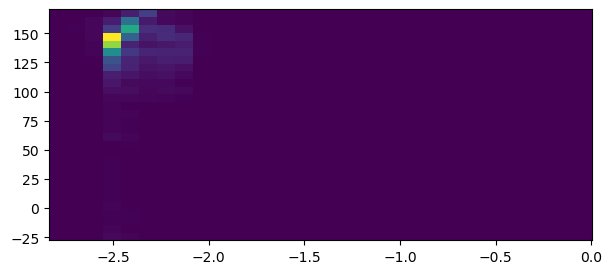

In [10]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

H,xedges,yedges = np.histogram2d(batch["cond"][:,0].cpu().numpy(), batch["d"][:, 8].cpu().numpy(), bins=30)
fig,ax = plt.subplots(figsize=(7, 3))

# ax = fig.add_subplot(131, title='imshow: square bins')
# plt.imshow(H, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# ax = fig.add_subplot(132, title='pcolormesh: actual edges',aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

# ax = fig.add_subplot(133, title='NonUniformImage: interpolated',aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
# im = NonUniformImage(ax, interpolation='bilinear')
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# im.set_data(xcenters, ycenters, H)
# ax.add_image(im)
# # plt.show()

[-1.5        -1.4848485  -1.469697   -1.4545455  -1.439394   -1.4242424
 -1.4090909  -1.3939394  -1.3787879  -1.3636364  -1.3484849  -1.3333334
 -1.3181818  -1.3030303  -1.2878788  -1.2727273  -1.2575758  -1.2424242
 -1.2272727  -1.2121212  -1.1969697  -1.1818181  -1.1666666  -1.1515151
 -1.1363636  -1.1212121  -1.1060606  -1.0909091  -1.0757575  -1.060606
 -1.0454545  -1.030303   -1.0151515  -1.         -0.9848485  -0.96969694
 -0.95454544 -0.93939394 -0.9242424  -0.9090909  -0.8939394  -0.8787879
 -0.8636364  -0.8484848  -0.8333333  -0.8181818  -0.80303025 -0.78787875
 -0.77272725 -0.75757575 -0.74242425 -0.72727275 -0.71212125 -0.69696975
 -0.6818182  -0.6666667  -0.6515152  -0.6363636  -0.6212121  -0.6060606
 -0.5909091  -0.5757576  -0.56060606 -0.54545456 -0.53030306 -0.5151515
 -0.5        -0.4848485  -0.469697   -0.45454547 -0.43939394 -0.42424244
 -0.40909094 -0.3939394  -0.37878788 -0.36363637 -0.34848487 -0.33333334
 -0.3181818  -0.3030303  -0.2878788  -0.27272728 -0.25757575

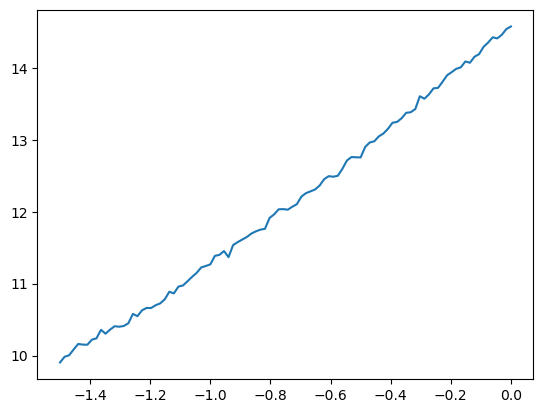

In [13]:
import matplotlib.pyplot as plt

# Get a batch of data
batch = train_dataset[:]

n_samples = 500

# Query the model for normalized disturbances.
d, cond = batch["d"].to(config.device), batch["cond"].to(config.device)
d = model.output_normalizer.normalize(d)

z = torch.linspace(-1.5,0.0,100)
u = torch.linspace(0,1,100)
mean = []
for z_ in z:
    cond = torch.zeros(1,12)
    cond[0,0] = z_
    pred_mean, pred_var = sample_outputs(model, cond, n_samples)
    mean.append(pred_mean.cpu().numpy())
mean = np.array(mean)
print(z.cpu().numpy())
print(mean.squeeze().shape)
plt.plot(z.cpu().numpy(),mean.squeeze()[:,8])

12692

In [40]:
im